In [13]:
import sys
sys.setrecursionlimit(10000)

import os
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("checkpoints", exist_ok=True)


In [14]:
def to_tensor(X, y):
    if hasattr(X, "to_numpy"):
        X = X.to_numpy()
    if hasattr(y, "to_numpy"):
        y = y.to_numpy()
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    return X_tensor, y_tensor


class TabularNet(nn.Module):
    def __init__(self, input_size, output_size=2, hidden_sizes=(256, 128, 64)):
        super().__init__()
        h1, h2, h3 = hidden_sizes
        self.model = nn.Sequential(
            nn.Linear(input_size, h1), nn.ReLU(),
            nn.Linear(h1, h2), nn.ReLU(),
            nn.Linear(h2, h3), nn.ReLU(),
            nn.Linear(h3, output_size)
        )

    def forward(self, x):
        return self.model(x)


In [15]:
def compute_spectral_norm(matrix):
    return torch.linalg.matrix_norm(matrix, ord=2)


def compute_l21_norm(matrix):
    return torch.sum(torch.linalg.norm(matrix, ord=2, dim=0))


def compute_spectral_complexity(model: nn.Module):
    product_terms = []
    summation_terms = []

    for module in model.modules():
        if isinstance(module, nn.Linear):
            A_i = module.weight.data
            s_i = compute_spectral_norm(A_i)

            M_i = torch.eye(A_i.size(0), A_i.size(1), device=A_i.device)
            deviation_matrix_T = A_i.T - M_i.T
            deviation_norm = compute_l21_norm(deviation_matrix_T)
            sum_term = (deviation_norm / (s_i + 1e-12)) ** (2 / 3)

            product_terms.append(s_i)
            summation_terms.append(sum_term)

    total_product = torch.prod(torch.stack(product_terms))
    total_sum = torch.sum(torch.stack(summation_terms))
    final_sum_term = total_sum ** (3 / 2)
    R_A = total_product * final_sum_term
    return R_A, total_product, final_sum_term


In [ ]:
def compute_dataset_l2_norm(loader):
    total_sq = 0.0
    with torch.no_grad():
        for batch in loader:
            if isinstance(batch, (list, tuple)):
                inputs = batch[0]
            else:
                inputs = batch
            total_sq += torch.sum(inputs.float() ** 2).item()
    return total_sq ** 0.5


In [16]:
def evaluate_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    return correct / max(total, 1)


def train_tabular_model(
    train_loader,
    val_loader,
    input_dim,
    num_classes,
    checkpoint_dir,
    checkpoint_epochs,
    total_epochs=120,
    lr=1e-3,
    dataset_label="TABULAR",
):
    os.makedirs(checkpoint_dir, exist_ok=True)
    model = TabularNet(input_dim, num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_history = []
    val_history = []

    for epoch in range(1, total_epochs + 1):
        model.train()
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{total_epochs}", leave=False)
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        train_acc = evaluate_accuracy(model, train_loader)
        val_acc = evaluate_accuracy(model, val_loader)
        train_history.append(train_acc)
        val_history.append(val_acc)

        if epoch in checkpoint_epochs:
            torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"epoch_{epoch}.pth"))

        print(f"[{dataset_label}] Epoch {epoch:03d} | Train Acc: {train_acc:.2%} | Val Acc: {val_acc:.2%}")

    return train_history, val_history


def collect_gamma_distribution(model, loader):
    diffs = []
    with torch.no_grad():
        pbar = tqdm(loader, desc="Eval", leave=False)
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            top2 = torch.topk(outputs, k=min(2, outputs.shape[1]), dim=1).values
            if outputs.shape[1] == 1:
                gamma_values = top2[:, 0]
            else:
                gamma_values = top2[:, 0] - top2[:, 1]
            diffs.extend(gamma_values.cpu().numpy())
    return np.array(diffs)


def compute_gamma_from_checkpoint(model_path, input_dim, num_classes, eval_loader):
    print(f"Loading checkpoint: {model_path}")
    model = TabularNet(input_dim, num_classes).to(device)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()

    print()
    print("Computing spectral complexity...")
    start_time = time.perf_counter()
    spectral_complexity, product_component, sum_component = compute_spectral_complexity(model)
    end_time = time.perf_counter()
    print(f"Product Component: {product_component.item():.4e}")
    print(f"Summation Component: {sum_component.item():.4e}")
    print(f"Total Spectral Complexity: {spectral_complexity.item():.4e}")
    print(f"Total Computation Time: {end_time - start_time:.4f}s")

    dataset_l2_norm = compute_dataset_l2_norm(eval_loader)
    diffs = collect_gamma_distribution(model, eval_loader)
    scaling = spectral_complexity.item() * dataset_l2_norm
    return diffs / scaling


def plot_accuracy_curves(train_hist, val_hist, dataset_label):
    epochs = range(1, len(train_hist) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_hist, label="Train Accuracy")
    plt.plot(epochs, val_hist, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{dataset_label} Accuracy Curves")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{dataset_label.lower()}_accuracy_curve.png")
    plt.show()


In [17]:
CHECKPOINT_DIR = "ckpt_tabular_adult"
CHECKPOINT_EPOCHS = [5, 40, 120]
TOTAL_EPOCHS = 120
BATCH_SIZE = 512

ADULT_COLUMNS = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
]

def prepare_adult_split(test_size=0.2, random_state=42):
    adult = pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
        names=ADULT_COLUMNS,
        na_values=" ?",
        skipinitialspace=True,
    ).dropna()
    X = adult.drop("income", axis=1)
    y = (adult["income"] == ">50K").astype(int)
    cat_cols = X.select_dtypes(include=["object"]).columns
    num_cols = X.select_dtypes(exclude=["object"]).columns
    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
    ])
    X_proc = preprocessor.fit_transform(X)
    Xt, Xv, yt, yv = train_test_split(
        X_proc,
        y,
        test_size=test_size,
        random_state=random_state,
        stratify=y,
    )
    Xt, yt = to_tensor(Xt, yt)
    Xv, yv = to_tensor(Xv, yv)
    train_loader = DataLoader(TensorDataset(Xt, yt), batch_size=BATCH_SIZE, shuffle=True)
    eval_loader = DataLoader(TensorDataset(Xv, yv), batch_size=BATCH_SIZE, shuffle=False)
    input_dim = Xt.shape[1]
    num_classes = 2
    return train_loader, eval_loader, input_dim, num_classes

os.makedirs(CHECKPOINT_DIR, exist_ok=True)


In [18]:
def compute_gamma_distribution(model_path):
    _, eval_loader, input_dim, num_classes = prepare_adult_split()
    return compute_gamma_from_checkpoint(model_path, input_dim, num_classes, eval_loader)

underfit = compute_gamma_distribution(os.path.join(CHECKPOINT_DIR, f"epoch_{CHECKPOINT_EPOCHS[0]}.pth"))
correct = compute_gamma_distribution(os.path.join(CHECKPOINT_DIR, f"epoch_{CHECKPOINT_EPOCHS[1]}.pth"))
overfit = compute_gamma_distribution(os.path.join(CHECKPOINT_DIR, f"epoch_{CHECKPOINT_EPOCHS[2]}.pth"))


Loading checkpoint: ckpt_tabular_adult/epoch_5.pth

Computing spectral complexity...
Product Component: 2.0095e+01
Summation Component: 2.5766e+02
Total Spectral Complexity: 5.1778e+03
Total Computation Time: 0.0467s


Loading checkpoint: ckpt_tabular_adult/epoch_40.pth

Computing spectral complexity...
Product Component: 7.8946e+02
Summation Component: 1.6634e+02
Total Spectral Complexity: 1.3132e+05
Total Computation Time: 0.0028s


Loading checkpoint: ckpt_tabular_adult/epoch_120.pth

Computing spectral complexity...
Product Component: 3.5887e+03
Summation Component: 1.7289e+02
Total Spectral Complexity: 6.2046e+05
Total Computation Time: 0.0025s


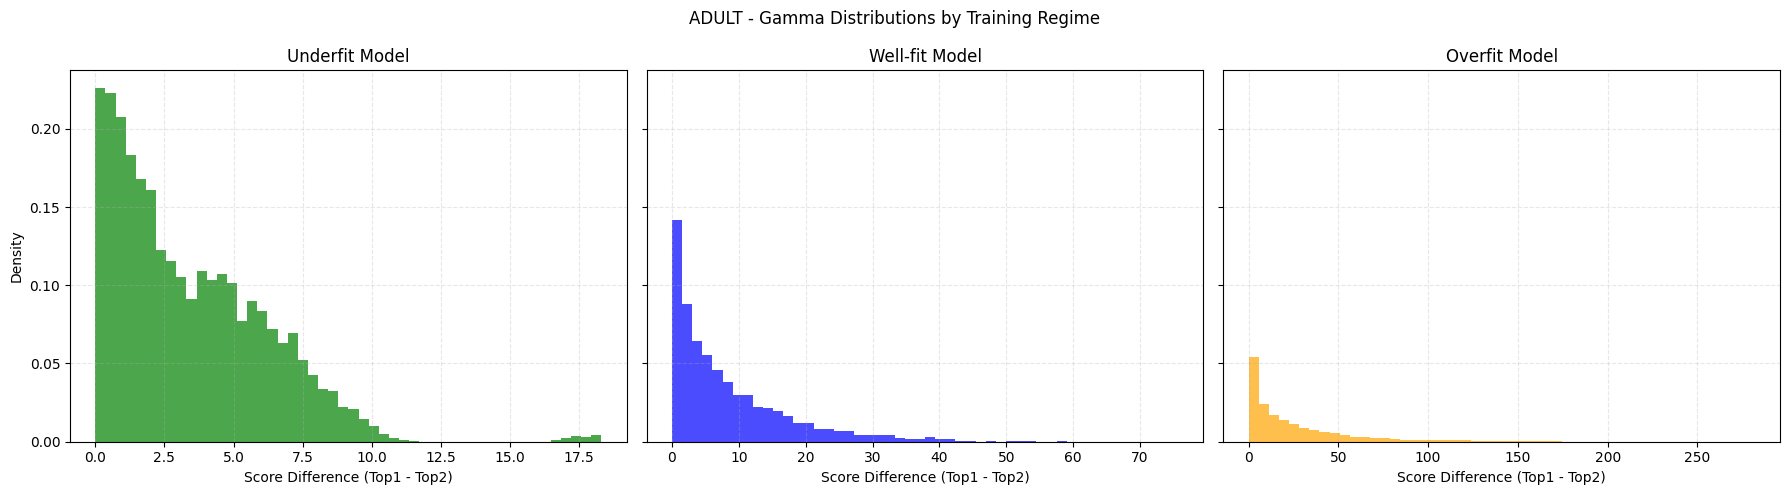

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
regimes = [
    (underfit, "Underfit", "green"),
    (correct, "Well-fit", "blue"),
    (overfit, "Overfit", "orange"),
]
for ax, (values, regime_label, color) in zip(axes, regimes):
    ax.hist(values, bins=50, alpha=0.7, color=color, density=True)
    ax.set_title(f"{regime_label} Model")
    ax.set_xlabel("Score Difference (Top1 - Top2)")
    ax.grid(True, linestyle='--', alpha=0.3)
axes[0].set_ylabel("Density")
fig.suptitle("ADULT - Gamma Distributions by Training Regime")
fig.tight_layout()
plt.show()


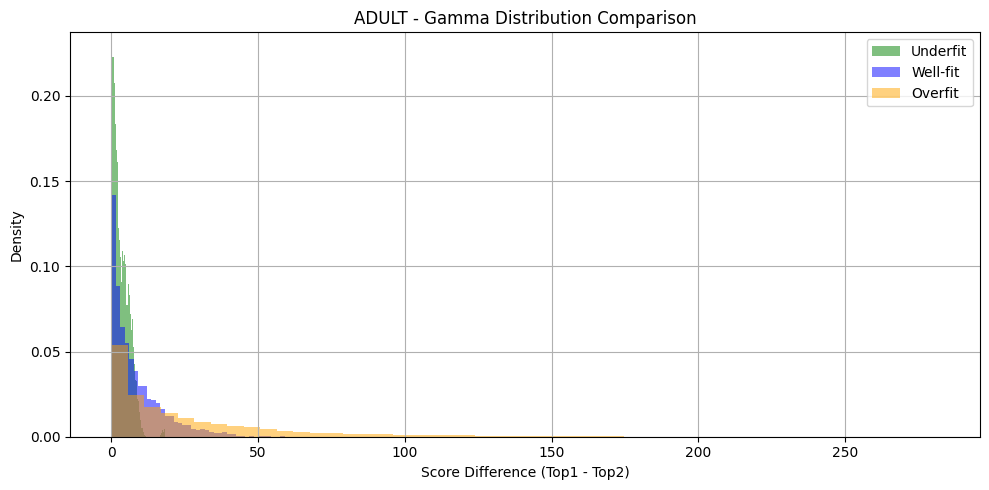

In [20]:
plt.figure(figsize=(10, 5))
plt.hist(underfit, bins=50, alpha=0.5, label="Underfit", color="green", density=True)
plt.hist(correct, bins=50, alpha=0.5, label="Well-fit", color="blue", density=True)
plt.hist(overfit, bins=50, alpha=0.5, label="Overfit", color="orange", density=True)
plt.xlabel("Score Difference (Top1 - Top2)")
plt.ylabel("Density")
plt.title("ADULT - Gamma Distribution Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("gamma_hist_spectral_norm_tabular_adult.png")
plt.show()


[ADULT] Epoch 001 | Train Acc: 84.79% | Val Acc: 85.18%


[ADULT] Epoch 002 | Train Acc: 85.74% | Val Acc: 85.66%


[ADULT] Epoch 003 | Train Acc: 86.04% | Val Acc: 86.03%


[ADULT] Epoch 004 | Train Acc: 86.26% | Val Acc: 85.97%


[ADULT] Epoch 005 | Train Acc: 86.31% | Val Acc: 85.84%


[ADULT] Epoch 006 | Train Acc: 86.52% | Val Acc: 85.78%


[ADULT] Epoch 007 | Train Acc: 86.49% | Val Acc: 85.84%


[ADULT] Epoch 008 | Train Acc: 86.95% | Val Acc: 85.92%


[ADULT] Epoch 009 | Train Acc: 87.12% | Val Acc: 85.74%


[ADULT] Epoch 010 | Train Acc: 87.42% | Val Acc: 85.77%


[ADULT] Epoch 011 | Train Acc: 87.65% | Val Acc: 85.75%


[ADULT] Epoch 012 | Train Acc: 87.75% | Val Acc: 85.46%


[ADULT] Epoch 013 | Train Acc: 87.95% | Val Acc: 85.41%


[ADULT] Epoch 014 | Train Acc: 88.16% | Val Acc: 85.18%


[ADULT] Epoch 015 | Train Acc: 88.67% | Val Acc: 85.44%


[ADULT] Epoch 016 | Train Acc: 88.20% | Val Acc: 84.91%


[ADULT] Epoch 017 | Train Acc: 88.67% | Val Acc: 84.94%


[ADULT] Epoch 018 | Train Acc: 88.49% | Val Acc: 85.11%


[ADULT] Epoch 019 | Train Acc: 89.30% | Val Acc: 85.21%


[ADULT] Epoch 020 | Train Acc: 89.16% | Val Acc: 85.21%


[ADULT] Epoch 021 | Train Acc: 89.58% | Val Acc: 84.55%


[ADULT] Epoch 022 | Train Acc: 89.33% | Val Acc: 84.81%


[ADULT] Epoch 023 | Train Acc: 89.40% | Val Acc: 84.32%


[ADULT] Epoch 024 | Train Acc: 89.44% | Val Acc: 84.71%


[ADULT] Epoch 025 | Train Acc: 89.91% | Val Acc: 84.57%


[ADULT] Epoch 026 | Train Acc: 88.73% | Val Acc: 83.16%


[ADULT] Epoch 027 | Train Acc: 90.38% | Val Acc: 84.32%


[ADULT] Epoch 028 | Train Acc: 89.68% | Val Acc: 84.45%


[ADULT] Epoch 029 | Train Acc: 90.23% | Val Acc: 83.88%


[ADULT] Epoch 030 | Train Acc: 90.44% | Val Acc: 84.20%


[ADULT] Epoch 031 | Train Acc: 90.89% | Val Acc: 84.58%


[ADULT] Epoch 032 | Train Acc: 90.16% | Val Acc: 82.51%


[ADULT] Epoch 033 | Train Acc: 91.06% | Val Acc: 84.32%


[ADULT] Epoch 034 | Train Acc: 91.65% | Val Acc: 84.22%


[ADULT] Epoch 035 | Train Acc: 91.53% | Val Acc: 84.54%


[ADULT] Epoch 036 | Train Acc: 91.22% | Val Acc: 83.59%


[ADULT] Epoch 037 | Train Acc: 91.22% | Val Acc: 84.22%


[ADULT] Epoch 038 | Train Acc: 92.25% | Val Acc: 83.49%


[ADULT] Epoch 039 | Train Acc: 92.30% | Val Acc: 83.53%


[ADULT] Epoch 040 | Train Acc: 92.35% | Val Acc: 84.06%


[ADULT] Epoch 041 | Train Acc: 91.70% | Val Acc: 84.40%


[ADULT] Epoch 042 | Train Acc: 92.08% | Val Acc: 82.96%


[ADULT] Epoch 043 | Train Acc: 92.40% | Val Acc: 83.54%


[ADULT] Epoch 044 | Train Acc: 92.91% | Val Acc: 84.14%


[ADULT] Epoch 045 | Train Acc: 92.96% | Val Acc: 84.00%


[ADULT] Epoch 046 | Train Acc: 92.79% | Val Acc: 84.08%


[ADULT] Epoch 047 | Train Acc: 92.53% | Val Acc: 83.89%


[ADULT] Epoch 048 | Train Acc: 92.46% | Val Acc: 84.17%


[ADULT] Epoch 049 | Train Acc: 93.16% | Val Acc: 84.14%


[ADULT] Epoch 050 | Train Acc: 93.04% | Val Acc: 83.88%


[ADULT] Epoch 051 | Train Acc: 92.23% | Val Acc: 83.23%


[ADULT] Epoch 052 | Train Acc: 93.47% | Val Acc: 83.10%


[ADULT] Epoch 053 | Train Acc: 93.54% | Val Acc: 83.69%


[ADULT] Epoch 054 | Train Acc: 93.37% | Val Acc: 83.60%


[ADULT] Epoch 055 | Train Acc: 92.74% | Val Acc: 83.11%


[ADULT] Epoch 056 | Train Acc: 93.54% | Val Acc: 83.43%


[ADULT] Epoch 057 | Train Acc: 93.28% | Val Acc: 83.51%


[ADULT] Epoch 058 | Train Acc: 93.12% | Val Acc: 83.13%


[ADULT] Epoch 059 | Train Acc: 93.73% | Val Acc: 83.71%


[ADULT] Epoch 060 | Train Acc: 93.50% | Val Acc: 82.19%


[ADULT] Epoch 061 | Train Acc: 94.20% | Val Acc: 83.40%


[ADULT] Epoch 062 | Train Acc: 93.15% | Val Acc: 83.82%


[ADULT] Epoch 063 | Train Acc: 93.95% | Val Acc: 84.12%


[ADULT] Epoch 064 | Train Acc: 94.43% | Val Acc: 83.76%


[ADULT] Epoch 065 | Train Acc: 93.27% | Val Acc: 82.27%


[ADULT] Epoch 066 | Train Acc: 93.87% | Val Acc: 82.99%


[ADULT] Epoch 067 | Train Acc: 94.42% | Val Acc: 83.11%


[ADULT] Epoch 068 | Train Acc: 93.80% | Val Acc: 83.05%


[ADULT] Epoch 069 | Train Acc: 94.60% | Val Acc: 82.68%


[ADULT] Epoch 070 | Train Acc: 94.51% | Val Acc: 83.14%


[ADULT] Epoch 071 | Train Acc: 94.71% | Val Acc: 83.28%


[ADULT] Epoch 072 | Train Acc: 94.49% | Val Acc: 83.19%


[ADULT] Epoch 073 | Train Acc: 94.76% | Val Acc: 83.19%


[ADULT] Epoch 074 | Train Acc: 94.00% | Val Acc: 82.67%


[ADULT] Epoch 075 | Train Acc: 94.14% | Val Acc: 83.48%


[ADULT] Epoch 076 | Train Acc: 94.35% | Val Acc: 82.91%


[ADULT] Epoch 077 | Train Acc: 94.70% | Val Acc: 83.71%


[ADULT] Epoch 078 | Train Acc: 94.71% | Val Acc: 82.68%


[ADULT] Epoch 079 | Train Acc: 94.26% | Val Acc: 82.50%


[ADULT] Epoch 080 | Train Acc: 95.03% | Val Acc: 83.28%


[ADULT] Epoch 081 | Train Acc: 94.93% | Val Acc: 83.59%


[ADULT] Epoch 082 | Train Acc: 94.77% | Val Acc: 82.05%


[ADULT] Epoch 083 | Train Acc: 94.92% | Val Acc: 83.51%


[ADULT] Epoch 084 | Train Acc: 94.85% | Val Acc: 82.56%


[ADULT] Epoch 085 | Train Acc: 95.13% | Val Acc: 83.11%


[ADULT] Epoch 086 | Train Acc: 95.26% | Val Acc: 83.17%


[ADULT] Epoch 087 | Train Acc: 94.96% | Val Acc: 83.05%


[ADULT] Epoch 088 | Train Acc: 95.01% | Val Acc: 82.59%


[ADULT] Epoch 089 | Train Acc: 95.07% | Val Acc: 82.76%


[ADULT] Epoch 090 | Train Acc: 94.66% | Val Acc: 82.70%


[ADULT] Epoch 091 | Train Acc: 94.86% | Val Acc: 82.99%


[ADULT] Epoch 092 | Train Acc: 94.16% | Val Acc: 82.27%


[ADULT] Epoch 093 | Train Acc: 94.67% | Val Acc: 83.48%


[ADULT] Epoch 094 | Train Acc: 95.04% | Val Acc: 83.94%


[ADULT] Epoch 095 | Train Acc: 95.55% | Val Acc: 83.11%


[ADULT] Epoch 096 | Train Acc: 94.93% | Val Acc: 83.80%


[ADULT] Epoch 097 | Train Acc: 95.84% | Val Acc: 82.60%


[ADULT] Epoch 098 | Train Acc: 95.27% | Val Acc: 82.71%


[ADULT] Epoch 099 | Train Acc: 95.50% | Val Acc: 83.46%


[ADULT] Epoch 100 | Train Acc: 95.71% | Val Acc: 82.45%


[ADULT] Epoch 101 | Train Acc: 95.26% | Val Acc: 83.10%


[ADULT] Epoch 102 | Train Acc: 95.45% | Val Acc: 83.14%


[ADULT] Epoch 103 | Train Acc: 95.51% | Val Acc: 83.06%


[ADULT] Epoch 104 | Train Acc: 95.58% | Val Acc: 82.79%


[ADULT] Epoch 105 | Train Acc: 95.54% | Val Acc: 83.02%


[ADULT] Epoch 106 | Train Acc: 95.72% | Val Acc: 83.19%


[ADULT] Epoch 107 | Train Acc: 95.59% | Val Acc: 82.07%


[ADULT] Epoch 108 | Train Acc: 95.30% | Val Acc: 82.51%


[ADULT] Epoch 109 | Train Acc: 95.70% | Val Acc: 83.05%


[ADULT] Epoch 110 | Train Acc: 95.29% | Val Acc: 82.67%


[ADULT] Epoch 111 | Train Acc: 95.60% | Val Acc: 82.68%


[ADULT] Epoch 112 | Train Acc: 95.64% | Val Acc: 83.20%


[ADULT] Epoch 113 | Train Acc: 95.57% | Val Acc: 82.08%


[ADULT] Epoch 114 | Train Acc: 95.87% | Val Acc: 82.42%


[ADULT] Epoch 115 | Train Acc: 95.85% | Val Acc: 83.17%


[ADULT] Epoch 116 | Train Acc: 94.79% | Val Acc: 82.88%


[ADULT] Epoch 117 | Train Acc: 95.72% | Val Acc: 83.43%


[ADULT] Epoch 118 | Train Acc: 95.87% | Val Acc: 82.83%


[ADULT] Epoch 119 | Train Acc: 95.97% | Val Acc: 82.47%


[ADULT] Epoch 120 | Train Acc: 96.19% | Val Acc: 82.79%


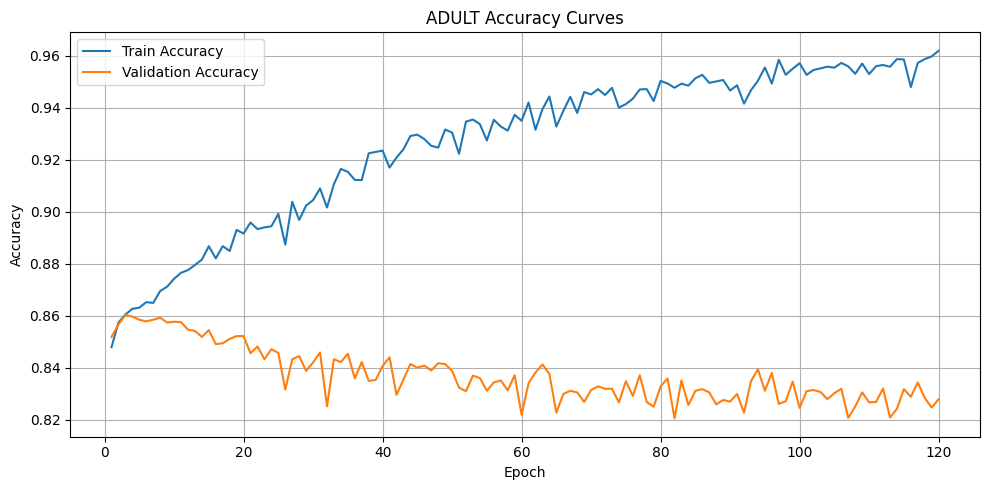

In [21]:
adult_train_loader, adult_eval_loader, adult_input_dim, adult_num_classes = prepare_adult_split()

adult_train_acc, adult_eval_acc = train_tabular_model(
    adult_train_loader,
    adult_eval_loader,
    adult_input_dim,
    adult_num_classes,
    CHECKPOINT_DIR,
    CHECKPOINT_EPOCHS,
    total_epochs=TOTAL_EPOCHS,
    lr=1e-3,
    dataset_label="ADULT",
)

plot_accuracy_curves(adult_train_acc, adult_eval_acc, "ADULT")
